In [277]:
# --------------------------------------------------------------
#
# L'objectif du present notebook est de tester le telechargement d'images de sentinel ainsi que quelques 
# algorithmes de machine learning ayant trait à la télédetection
# voir le tutoriel https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/data_download_process_request.html
# S'inscrire sur https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings et générer un jetton
# ----------------------------------------------------------------

In [2]:
# l'api accessible depuis "https://scihub.copernicus.eu/dhus" n'est plus disponible (depuis 2023)

In [75]:
# Installer les packages manquantes (si necessaire)
! pip install oauthlib;
! pip install requests_oauthlib;
! pip install sentinelhub;
! pip install ipyleaflet;

  Using cached ipyleaflet-0.19.2-py3-none-any.whl.metadata (5.3 kB)
  Using cached jupyter_leaflet-0.19.2-py3-none-any.whl.metadata (2.4 kB)
  Using cached traittypes-0.2.1-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)
Using cached ipyleaflet-0.19.2-py3-none-any.whl (31 kB)
Using cached jupyter_leaflet-0.19.2-py3-none-any.whl (1.1 MB)
Using cached traittypes-0.2.1-py2.py3-none-any.whl (8.6 kB)
Using cached webcolors-24.11.1-py3-none-any.whl (14 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)


In [119]:
! pip install folium # Pour l'affichage de l'image apres téléchargement

In [4]:
# Downgrader NumPy , sentinelhub oblige
! pip install "numpy<2"

In [ ]:
import os
from dotenv import load_dotenv
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

import datetime,getpass
import matplotlib.pyplot as plt
import numpy as np # Actuellement sentinelhub necessite Numpy 1.x
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


In [264]:
# recuperation des identifiant depuis le .env (voir ReadMe)
load_dotenv()
SH_CLIENT_ID = os.getenv("SH_CLIENT_ID")
SH_CLIENT_SECRET = os.getenv("SH_CLIENT_SECRET")

In [268]:
#SH_CLIENT_ID

# Authentification

In [152]:
# Ne pas executer la partie authentification plusieurs fois afin d'economiser de la ressource

In [279]:
# Se référer à deforestation_monitoring_with_xarray.ipynb present dans jupyterhub.dataspace.copernicus.eu
your_profil_name="kenpachi_sn" # se trouve dans https://apps.sentinel-hub.com/dashboard/#/account/settings

# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = SH_CLIENT_ID
config.sh_client_secret = SH_CLIENT_SECRET
#config.sh_token_url = "https://services.sentinel-hub.com/oauth/token"
#config.sh_base_url = "https://services.sentinel-hub.com"


config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save(your_profil_name) 

In [281]:
# Si vous avez deja configurer votre profil :
config = SHConfig(your_profil_name) 

# Définition de la zone d'intérêt

In [178]:

# https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/data_download_process_request.html
# http://bboxfinder.com/ # pour selectionner la zone

In [283]:
kafountine_coords_wgs84_EPSG4326 = (-16.752365,12.909166,-16.723526,12.936625)
resolution =10 # La resolution de l'image en métre
kafountine_bbox =BBox(bbox=kafountine_coords_wgs84_EPSG4326, crs=CRS.WGS84)
kafountine_size =bbox_to_dimensions(kafountine_bbox, resolution=resolution)
print(f"Image shape at {resolution} m resolution: {kafountine_size} pixels")

Image shape at 10 m resolution: (315, 302) pixels


# Télécharger une image "True color" format PNG pour une date donnée

In [240]:
# Nous nous interessons aux bandes  B02 ,B03 et B04 de Sentinel-2 L1C
# Sans paramètres supplémentaires dans le script d'évaluation, les données téléchargées correspondront aux valeurs de réflectance au UINT8format
# (valeurs comprises entre 0 et 255).Donc pas de probleme d'affichage avec matplotlib

In [307]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2", service_url=config.sh_base_url
            ),
            time_interval=("2024-10-12", "2024-10-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=kafountine_bbox,
    size=kafountine_size,
    config=config,
)

In [299]:
print([collection.name for collection in DataCollection])

['SENTINEL2_L1C', 'SENTINEL2_L2A', 'SENTINEL1', 'SENTINEL1_IW', 'SENTINEL1_IW_ASC', 'SENTINEL1_IW_DES', 'SENTINEL1_EW', 'SENTINEL1_EW_ASC', 'SENTINEL1_EW_DES', 'SENTINEL1_EW_SH', 'SENTINEL1_EW_SH_ASC', 'SENTINEL1_EW_SH_DES', 'DEM', 'DEM_MAPZEN', 'DEM_COPERNICUS_30', 'DEM_COPERNICUS_90', 'MODIS', 'LANDSAT_MSS_L1', 'LANDSAT_TM_L1', 'LANDSAT_TM_L2', 'LANDSAT_ETM_L1', 'LANDSAT_ETM_L2', 'LANDSAT_OT_L1', 'LANDSAT_OT_L2', 'SENTINEL5P', 'SENTINEL3_OLCI', 'SENTINEL3_SLSTR', 'HARMONIZED_LANDSAT_SENTINEL', 's2l1c', 's2']


In [301]:
true_color_imgs = request_true_color.get_data() # image sous format tableau numpy

In [303]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (302, 315, 3)


<p style="color: red; font-size: 30px;">Attention à la date de collecte des images </p>

En fonction de la date chosie, l'image en sortie peut être noir , se servir de la plateforme https://browser.dataspace.copernicus.eu/ pour le choix des dates

In [305]:
true_color_imgs[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [295]:
import folium
map = folium.Map(location=[(kafountine_coords_wgs84_EPSG4326[1] + kafountine_coords_wgs84_EPSG4326[3]) / 2, (kafountine_coords_wgs84_EPSG4326[0] + kafountine_coords_wgs84_EPSG4326[2]) / 2], zoom_start=15)
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=False,
    control=True
).add_to(map)
folium.raster_layers.ImageOverlay(
    image=true_color_imgs[0],
    bounds=[[kafountine_coords_wgs84_EPSG4326[1], kafountine_coords_wgs84_EPSG4326[0]], [kafountine_coords_wgs84_EPSG4326[3], kafountine_coords_wgs84_EPSG4326[2]]],
    opacity=1,
).add_to(map)
folium.Rectangle(
    bounds=[[kafountine_coords_wgs84_EPSG4326[1], kafountine_coords_wgs84_EPSG4326[0]], [kafountine_coords_wgs84_EPSG4326[3], kafountine_coords_wgs84_EPSG4326[2]]],  # Coordinates of the bounding box
    color="orange",  # Color of the rectangle
    weight=4,     # Line thickness
    fill=False    # Set to False to make it a simple outline
).add_to(map)


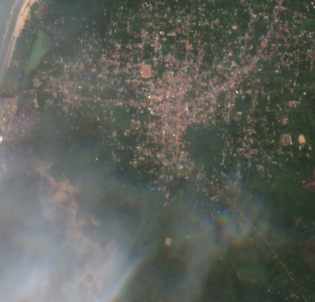

In [254]:
map